### Note:
This notebook is aimed at getting a handle on how the FFT spectral resolution convolution works, and how we can modify it to have wavelength-dependent spectral resolution.  See Issue #8 in the `jammer` repository.

In [ ]:
import Starfish

In [2]:
import os

In [3]:
from Starfish.grid_tools import HDF5Creator

In [4]:
instrument = eval("Starfish.grid_tools." + Starfish.data["instruments"][0])()

In [5]:
instrument.FWHM

1070.0

In [6]:
instrument.name

'SPEX_PRZ'

In [7]:
try:
    air = instrument.air
    print("New in v0.3: Using explicit air/vacuum state from Instrument class.")
except AttributeError:
    air = True

New in v0.3: Using explicit air/vacuum state from Instrument class.


In [8]:
    if (Starfish.data["grid_name"] == "PHOENIX") & (len(Starfish.grid['parname']) == 3):
        mygrid = eval("Starfish.grid_tools." + Starfish.data["grid_name"]+ "GridInterfaceNoAlpha")(air=air)
    else:
        mygrid = eval("Starfish.grid_tools." + Starfish.data["grid_name"]+ "GridInterface")(air=air)

In [9]:
hdf5_path = os.path.expandvars(Starfish.grid["hdf5_path"])

In [10]:
Starfish.grid["parrange"]

[[500, 1000], [4.0, 5.5]]

In [11]:
creator = HDF5Creator(mygrid, hdf5_path, instrument,
                      ranges=Starfish.grid["parrange"])

FFT grid stretches from 9499.999999999996 to 25500.00000000002
wl_FFT dv is 1.1291990606291067 km/s


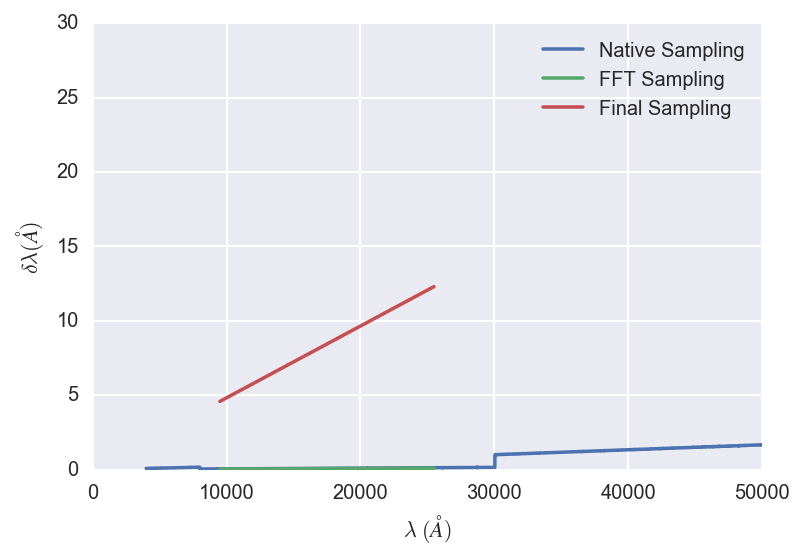

In [12]:
plt.plot(creator.wl_native[:-1], np.diff(creator.wl_native), label='Native Sampling')
plt.plot(creator.wl_FFT[:-1], np.diff(creator.wl_FFT), label='FFT Sampling')
plt.plot(creator.wl_final[:-1], np.diff(creator.wl_final), label='Final Sampling')
plt.ylabel('$\delta \lambda (\AA)$')
plt.xlabel('$\lambda \; (\AA)$')
plt.ylim(0,30)
plt.legend(loc='best');

Starfish's `grid_tools` slightly oversamples the spectrum with linear interpolation between the pixels.

In [13]:
creator.dv_native, creator.dv_FFT, creator.dv_final

(1.3865401182598156, 1.1291990606291067, 144.64214703882612)

In [14]:
creator.wl_final

array([  9500.        ,   9504.58350556,   9509.16922254, ...,
        25475.41160861,  25487.7028392 ,  25500.        ])

In [15]:
creator.points

[array([ 500,  525,  550,  575,  600,  650,  700,  750,  800,  850,  900,
         950, 1000]), array([ 4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ])]

In [16]:
import itertools

In [17]:
param_list = []

# use itertools.product to create permutations of all possible values
for i in itertools.product(*creator.points):
    param_list.append(np.array(i))

all_params = np.array(param_list)

In [18]:
test_par = [800.0, 5.0]

In [19]:
creator.Instrument.FWHM

1070.0

In [20]:
#creator.Instrument.FWHM = 9200.0/2.0

In [21]:
sigma = creator.Instrument.FWHM / 2.35 # in km/s

In [22]:
print(creator.Instrument)

Instrument Name: SPEX_PRZ, FWHM: 1070.0, oversampling: 4.0, wl_range: (6500, 27000)


In [23]:
#creator.taper = np.exp(-2 * (np.pi ** 2) * (sigma ** 2) * (creator.ss ** 2))

In [24]:
fl, header = creator.process_flux(test_par)

Processing [800.0, 5.0]


In [25]:
raw, hdr = mygrid.load_flux(test_par)

In [26]:
sns.set_context('poster', font_scale=1.7)

In [27]:
wl = creator.wl_final

## Read the data and previous models

In [28]:
import pandas as pd

In [29]:
dat1 = pd.read_csv('../../sf/Gl570D/output/marley_grid/run01/spec_config.csv')
#dat2 = pd.read_csv('../sf/Gl570D/output/marley_grid/run01/models_draw.csv')

Read .flx files from Mark on April 20, 2017

In [30]:
dat_MM_flx = pd.read_csv('./t800g1000nc.flx', delim_whitespace=True, 
                         names = ['id', 'wl_um', 'junk', 'flux_density_per_hz'])

In [31]:
dat_MM_flx2 = pd.read_csv('./t800g1000nc_16.flx', delim_whitespace=True, 
                          names = ['id', 'wl_um', 'junk', 'flux_density_per_hz'])

In [32]:
import astropy.units as u

In [33]:
x = dat_MM_flx.wl_um.values*u.micron
f = dat_MM_flx.flux_density_per_hz
f = (f.values*u.erg/u.cm**2/u.s/u.Hz).to(
             u.erg/u.cm**2/u.s/u.Angstrom, 
             equivalencies=u.spectral_density(x))

In [34]:
x2 = dat_MM_flx2.wl_um.values*u.micron
f2 = dat_MM_flx2.flux_density_per_hz
f2 = (f2.values*u.erg/u.cm**2/u.s/u.Hz).to(
             u.erg/u.cm**2/u.s/u.Angstrom, 
             equivalencies=u.spectral_density(x))

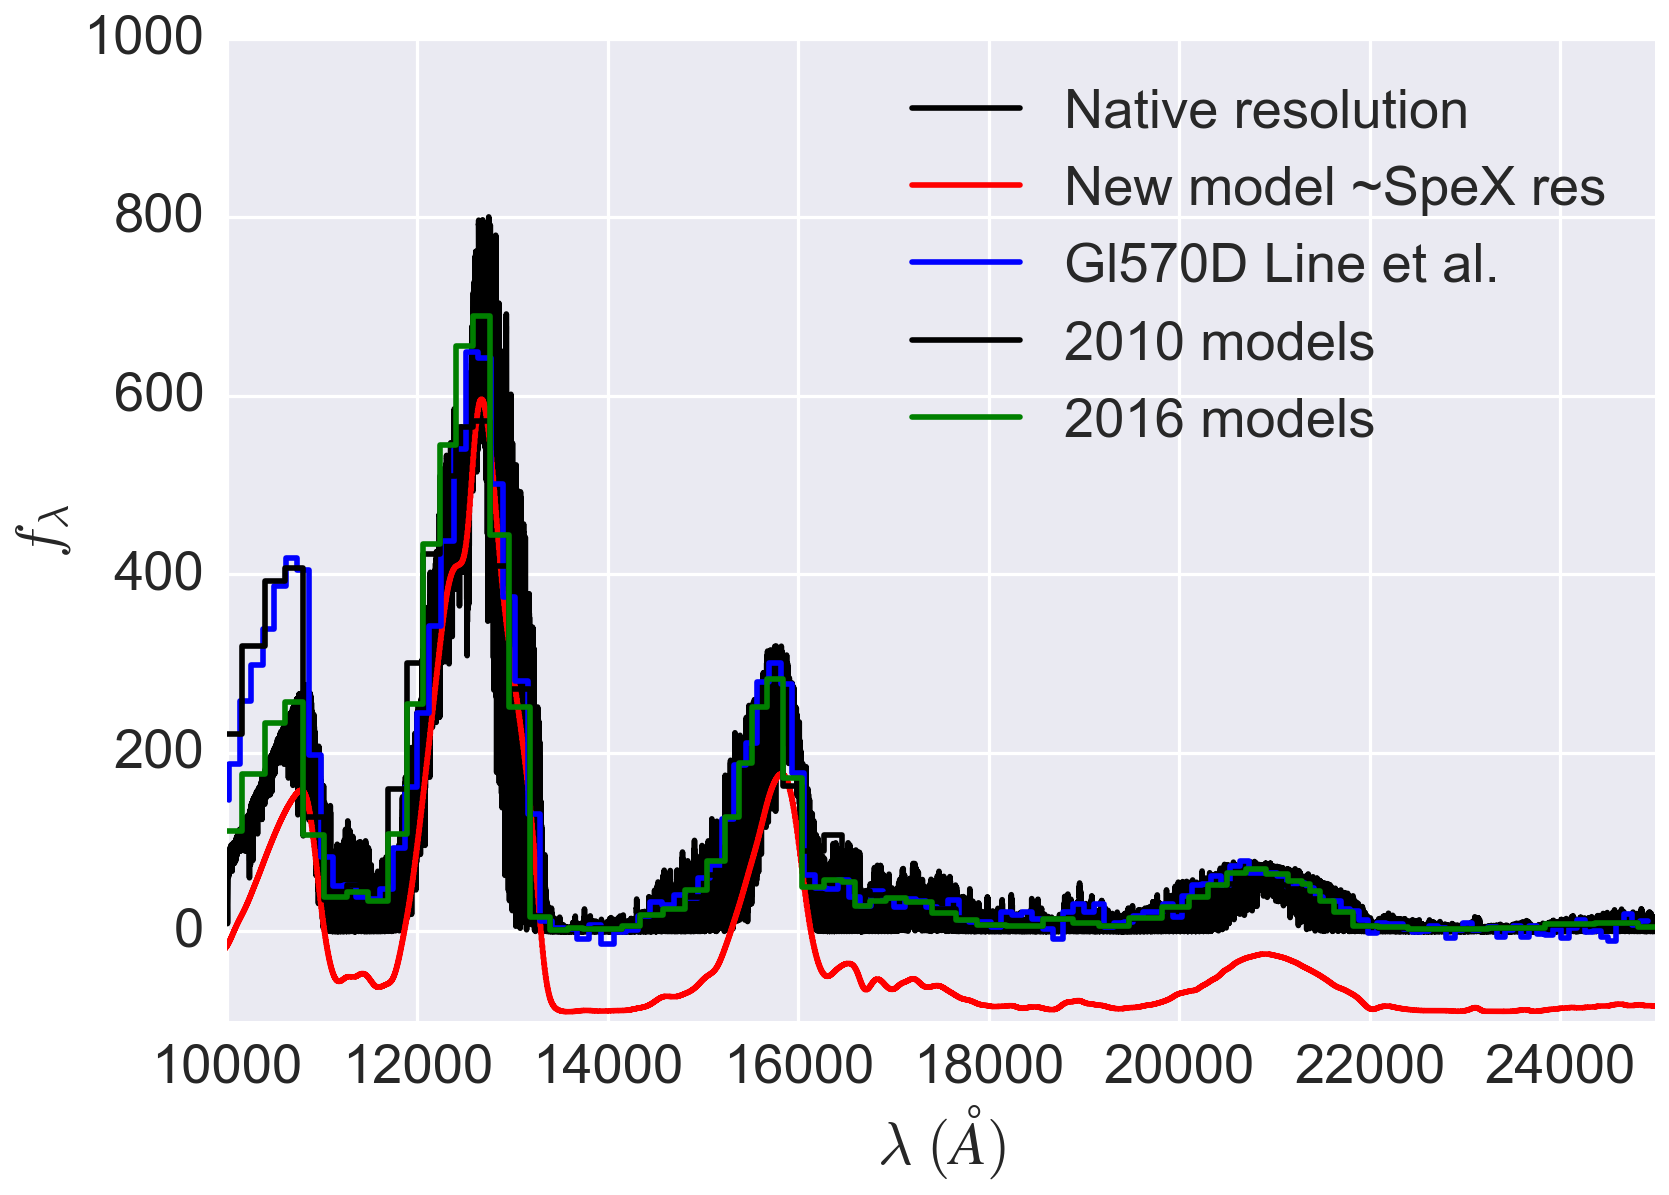

In [35]:
plt.plot(creator.wl_native, raw/3, 'k-', ms=0.5, alpha=1, label='Native resolution')
plt.step(wl, fl/3, 'r', label='New model ~SpeX res')
plt.step(dat1.wl, dat1.data*10**18, 'b-', ms=0.5, alpha=1, label='Gl570D Line et al.')
plt.step(x*10000.0, f/9, 'k', label = '2010 models')
plt.step(x2*10000.0, f2/9, 'g', label = '2016 models')
plt.xlim(10000, 25000)
plt.ylim(-100, 1000)
#plt.yscale('log')
plt.xlabel('$\lambda\; (\AA)$')
plt.ylabel('$f_\lambda$')
plt.legend(loc='best')
#plt.savefig('../../results/ex_model_spectrum.pdf', bbox_inches='tight');

### Key FFT programming idea-- 
The `ss[0]` term is the DC component-- it controls the average flux level.  The hack in `grid_tools.py` setting `ss[0]` to a non-zero value corrupted the average flux level when the taper was re-computed after updating `ss[0]`.  
**I have simply turned off the ss[0] = 0.01 hack.**

In [36]:
len(wl), len(fl)

(2048, 2048)

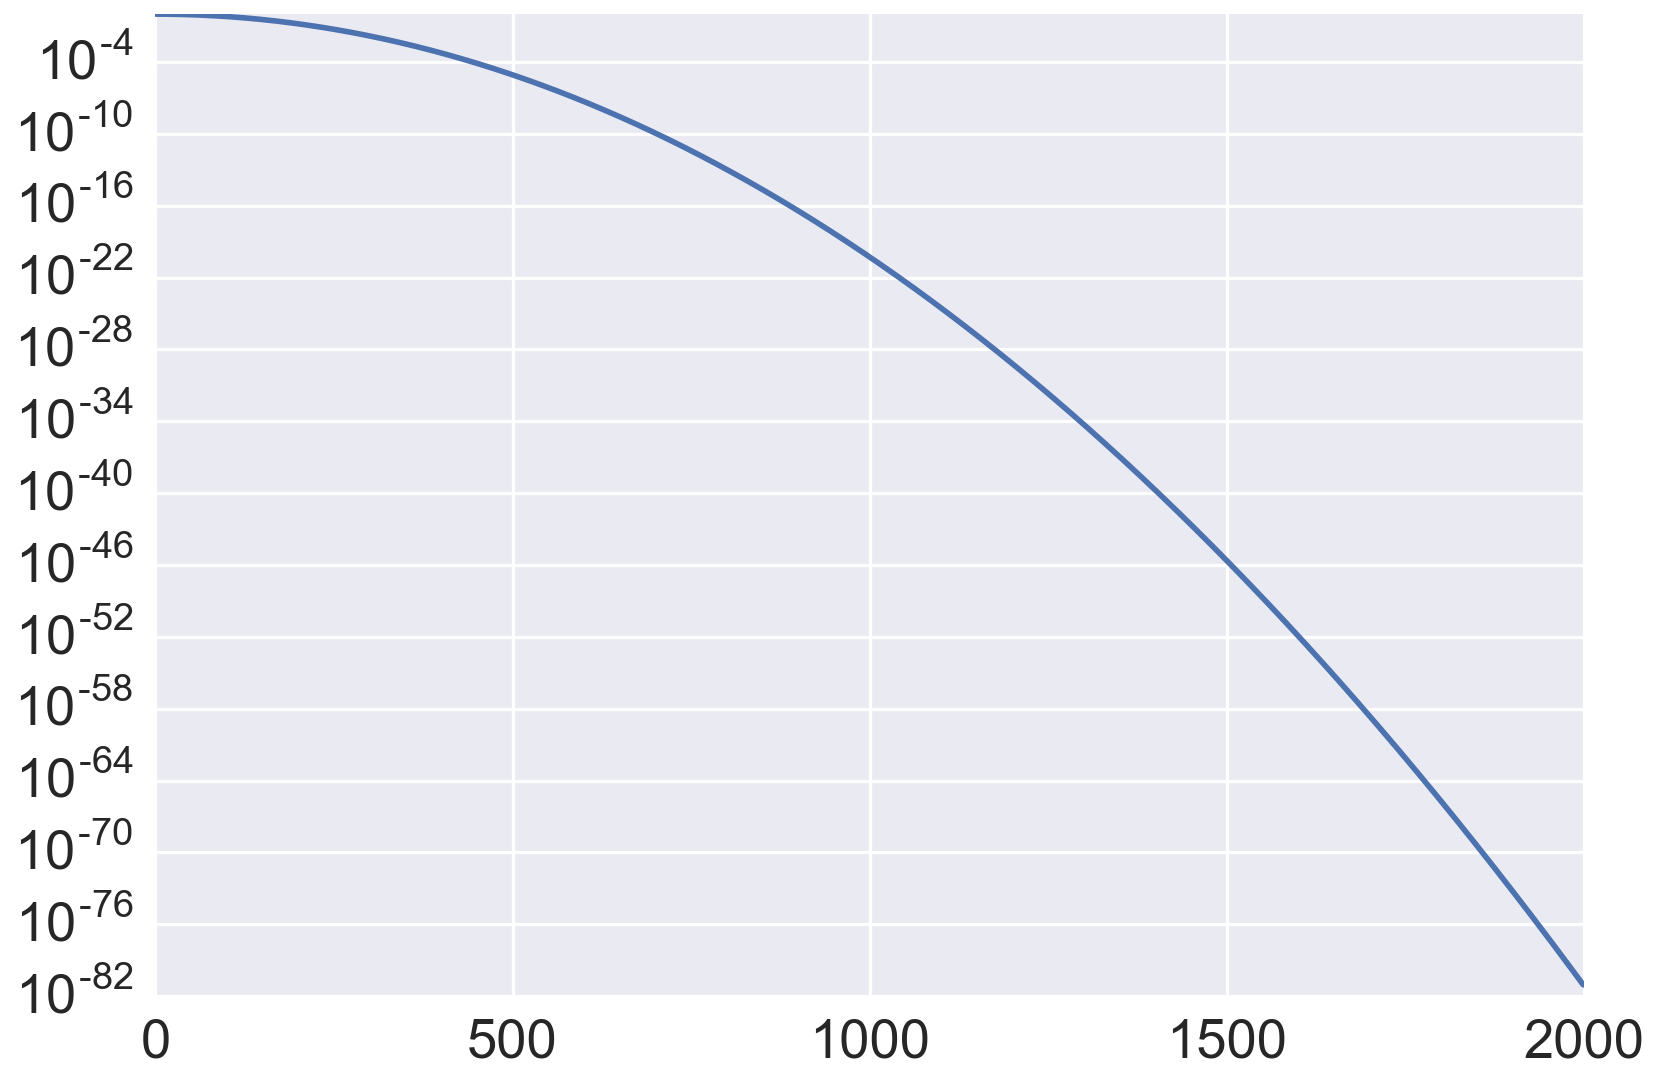

In [37]:
plt.plot(creator.taper[0:2000])
plt.yscale('log')

## The FFT step.

In [38]:
from numpy.fft import fft, ifft, fftfreq, rfftfreq

In [39]:
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d

In [40]:
# Interpolate the native spectrum to a log-lam FFT grid
interp = InterpolatedUnivariateSpline(creator.wl_native, raw, k=5)

In [41]:
fl = interp(creator.wl_FFT)
del interp

In [42]:
# Do the FFT
FF = np.fft.rfft(fl)

In [43]:
FF_tap = FF * creator.taper

In [44]:
FF.shape

(131073,)

In [45]:
n_pix, = creator.wl_final.shape

In [47]:
fl_final = creator.wl_final*0.0

In [48]:
n_pix//8

256

FWHM = 299792.46/R

In [49]:
for j in range(n_pix//8):
    #R_est = np.mean(creator.Instrument.res_gradient(creator.wl_final[j:j+8]))
    #sigma = 299792.46/R_est / 2.35 # in km/s
    # Instrumentally broaden the spectrum by multiplying with a Gaussian in Fourier space
    #creator.taper = np.exp(-2 * (np.pi ** 2) * (sigma ** 2) * (self.ss ** 2))
    FF_tap = FF * creator.taper
    fl_tapered = np.fft.irfft(FF_tap)
    interp = InterpolatedUnivariateSpline(creator.wl_FFT, fl_tapered, k=5)
    fl_final[8*j:8*j+8] = interp(creator.wl_final[8*j:8*j+8])

In [50]:
fl_final_orig = fl_final.copy()

In [51]:
import gc

In [59]:
for j in range(n_pix//8):
    R_est = np.mean(creator.Instrument.res_gradient()(creator.wl_final[8*j:8*j+8]))
    sigma = 299792.46/R_est / 2.35 # in km/s
    # Instrumentally broaden the spectrum by multiplying with a Gaussian in Fourier space
    creator.ss[0] = 0.00
    taper = np.exp(-2 * (np.pi ** 2) * (sigma ** 2) * (creator.ss ** 2))
    FF_tap = FF * taper
    fl_tapered = np.fft.irfft(FF_tap)
    interp = InterpolatedUnivariateSpline(creator.wl_FFT, fl_tapered, k=5)
    fl_final[8*j:8*j+8] = interp(creator.wl_final[8*j:8*j+8])
    del interp
    gc.collect()

In [60]:
fl_final.shape

(2048,)

In [54]:
fl_fin_multi = np.empty((2048, 256))

In [55]:
R_trial = np.arange(50, 50+256)

In [62]:
for j in range(256):
    R_est = R_trial[j]
    sigma = 299792.46/R_est / 2.35 # in km/s
    # Instrumentally broaden the spectrum by multiplying with a Gaussian in Fourier space
    taper = np.exp(-2 * (np.pi ** 2) * (sigma ** 2) * (creator.ss ** 2))
    creator.ss[0] = 0.00
    FF_tap = FF * taper
    fl_tapered = np.fft.irfft(FF_tap)
    interp = InterpolatedUnivariateSpline(creator.wl_FFT, fl_tapered, k=5)
    fl_fin_multi[:, j] = interp(creator.wl_final)
    del interp
    gc.collect()

In [57]:
sns.set_context('notebook')

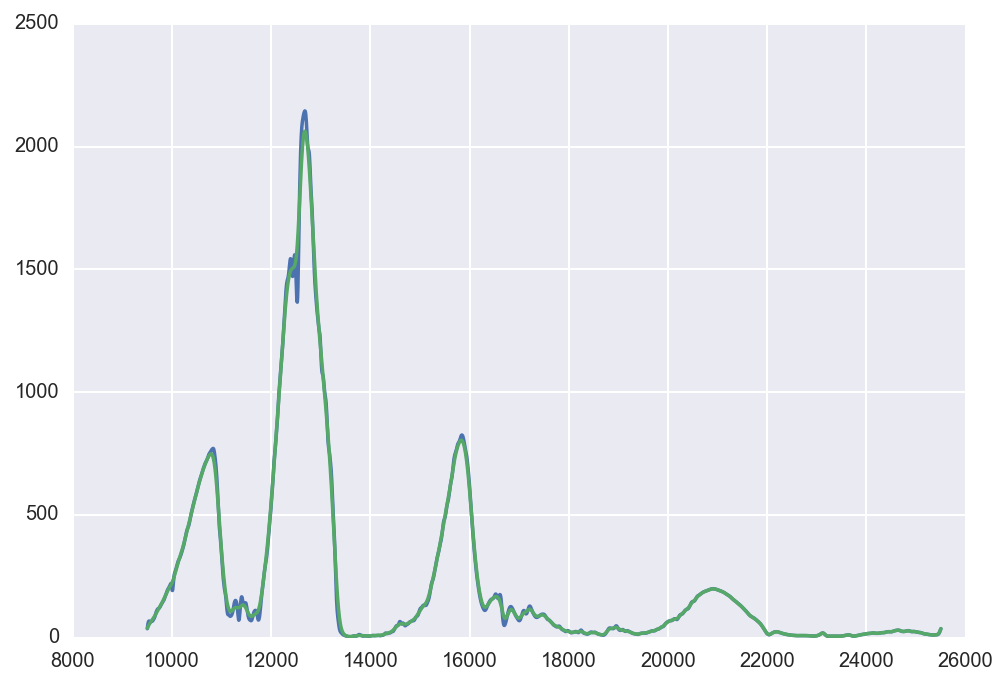

In [64]:
plt.plot(creator.wl_final, fl_final_orig)
plt.plot(creator.wl_final, fl_final)
#for j in range(256):
#    plt.plot(creator.wl_final, fl_fin_multi[:, j], alpha=0.1)


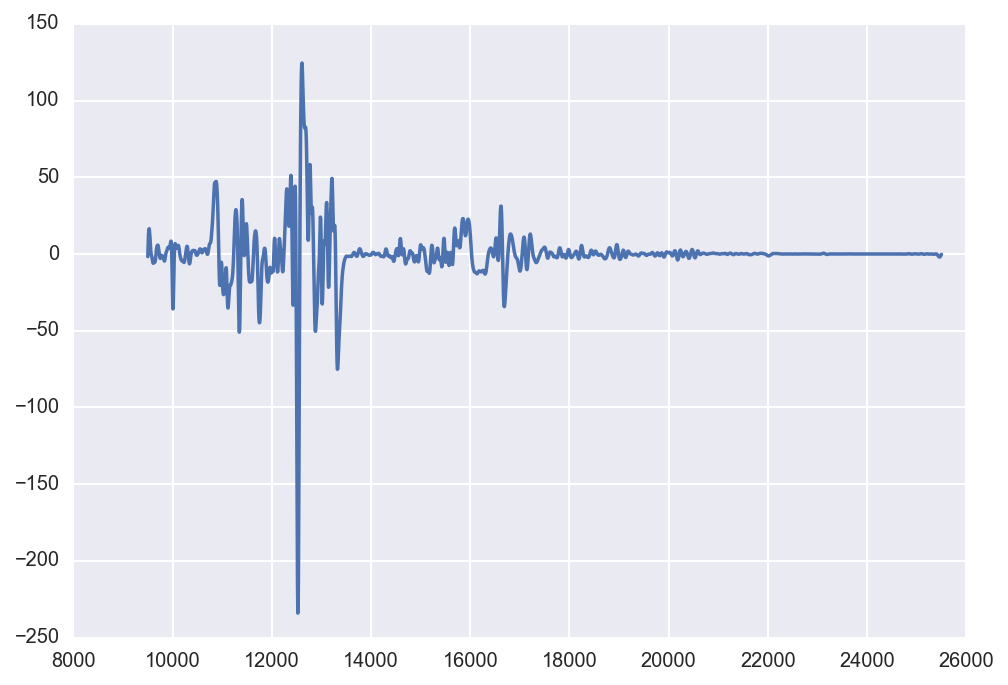

In [67]:
plt.plot(creator.wl_final, (fl_final_orig-fl_final))

WTF is with that??

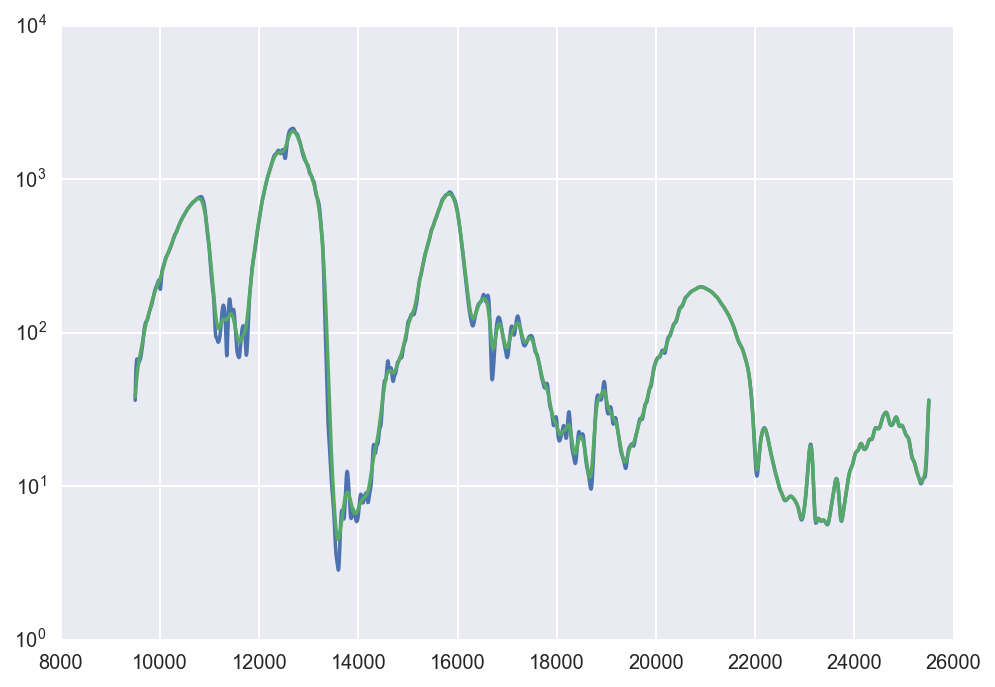

In [61]:
plt.plot(creator.wl_final, fl_final_orig)
plt.plot(creator.wl_final, fl_final-np.min(fl_final-4.5))
plt.yscale('log')

OK, so this looks good-- matching resolution at long wavelengths (expected behavior), with lower resolution at shorter wavelengths (expected).

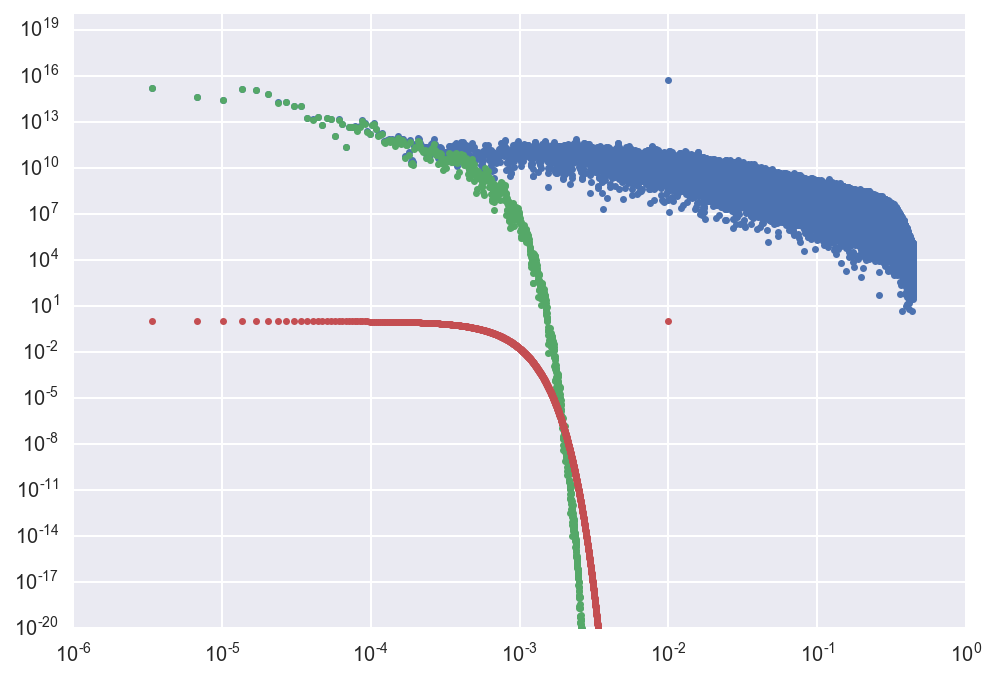

In [63]:
plt.plot(creator.ss, np.abs(FF**2), '.')
plt.plot(creator.ss, np.abs(FF_tap**2), '.')
plt.plot(creator.ss, creator.taper, '.')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.0e-20, 1.0e20);